# Time a pulsar

This notebook walks through a simple pulsar timing session, as one might do with TEMPO/TEMPO2: load a `.par` file, load a `.tim` file, do a fit, plot the residuals before and after. This one also displays various additional information you might find useful, and also ignores but then plots TOAs with large uncertainties. Similar code is available as a standalone script at [fit_NGC6440E.py](https://github.com/nanograv/PINT/blob/master/docs/examples/fit_NGC6440E.py)

In [1]:
import astropy.units as u
import matplotlib.pyplot as plt

import pint.fitter
from pint.models import get_model_and_toas
from pint.residuals import Residuals
import pint.logging

pint.logging.setup(level="INFO")

1


We want to load a parameter file and some TOAs. For the purposes of this notebook, we'll load in ones that are included with PINT; the `pint.config.examplefile()` calls return the path to where those files are in the PINT distribution. If you wanted to use your own files, you would probably know their filenames and could just set `parfile="myfile.par"` and `timfile="myfile.tim"`.

In [2]:
import pint.config

parfile = pint.config.examplefile("NGC6440E.par")
timfile = pint.config.examplefile("NGC6440E.tim")

Let's load the par and tim files. We could load them separately with the `get_model` and `get_TOAs` functions, but the parfile may contain information about how to interpret the TOAs, so it is convenient to load the two together so that the TOAs take into account details in the par file.

In [3]:
m, t_all = get_model_and_toas(parfile, timfile)
m

TimingModel(
  AbsPhase(
    MJDParameter(   TZRMJD              53801.3860512007484954 (d) frozen=True),
    strParameter(   TZRSITE             1                 frozen=True),
    floatParameter( TZRFRQ              1949.609          (MHz) frozen=True)),
  AstrometryEquatorial(
    MJDParameter(   POSEPOCH            53750.0000000000000000 (d) frozen=True),
    floatParameter( PX                  0.0               (mas) frozen=True),
    AngleParameter( RAJ                 17:48:52.75000000 (hourangle) +/- 0h00m00.05s frozen=False),
    AngleParameter( DECJ                -20:21:29.00000000 (deg) +/- 0d00m00.4s frozen=False),
    floatParameter( PMRA                0.0               (mas / yr) frozen=True),
    floatParameter( PMDEC               0.0               (mas / yr) frozen=True)),
  DispersionDM(
    floatParameter( DM                  223.9             (pc / cm3) +/- 0.3 pc / cm3 frozen=False),
    floatParameter( DM1                 UNSET,
    MJDParameter(   DMEPOCH      

There are many messages here. As a rule messages marked `INFO` can safely be ignored, they are simply informational; take a look at them if something unexpected happens. Messages marked `WARNING` or `ERROR` are more serious. (These messages are emitted by the python `logger` module and can be suppressed or written to a log file if they are annoying.)

Let's just print out a quick summary.

In [4]:
t_all.print_summary()

Number of TOAs:  62
Number of commands:  0
Number of observatories: 1 ['gbt']
MJD span:  53478.286 to 54187.587
Date span: 2005-04-18 06:51:39.290648106 to 2007-03-28 14:05:44.808308037
gbt TOAs (62):
  Min freq:      1549.609 MHz
  Max freq:      2212.109 MHz
  Min error:     13.2 us
  Max error:     118 us
  Median error:  22.1 us



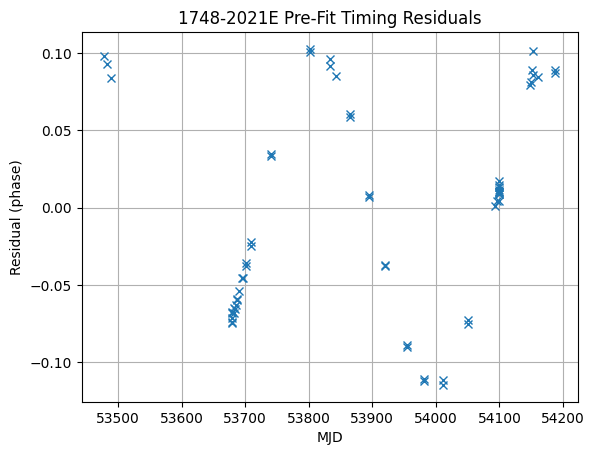

In [5]:
rs = Residuals(t_all, m).phase_resids
xt = t_all.get_mjds()
plt.figure()
plt.plot(xt, rs, "x")
plt.title(f"{m.PSR.value} Pre-Fit Timing Residuals")
plt.xlabel("MJD")
plt.ylabel("Residual (phase)")
plt.grid()

We could proceed immediately to fitting the par file, but some of those uncertainties seem a little large. Let's discard the data points with uncertainties $>30\,\mu\text{s}$ - uncertainty estimation is not always reliable when the signal-to-noise is low.

In [6]:
error_ok = t_all.table["error"] <= 30 * u.us
t = t_all[error_ok]
t.print_summary()

Number of TOAs:  44
Number of commands:  0
Number of observatories: 1 ['gbt']
MJD span:  53478.286 to 54187.587
Date span: 2005-04-18 06:51:39.290648106 to 2007-03-28 14:05:44.808308037
gbt TOAs (44):
  Min freq:      1724.609 MHz
  Max freq:      1949.609 MHz
  Min error:     13.2 us
  Max error:     29.9 us
  Median error:  21.5 us



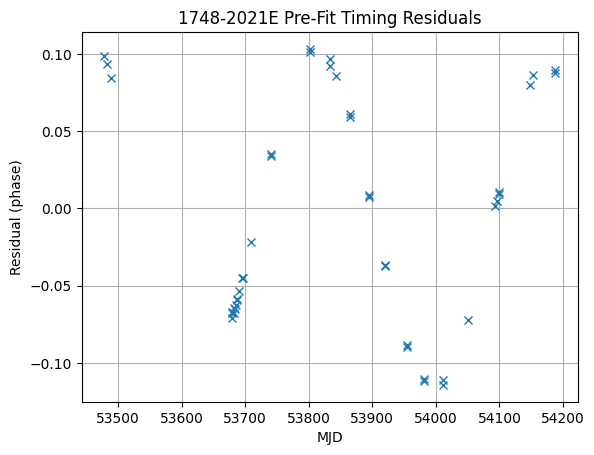

In [7]:
rs = Residuals(t, m).phase_resids
xt = t.get_mjds()
plt.figure()
plt.plot(xt, rs, "x")
plt.title(f"{m.PSR.value} Pre-Fit Timing Residuals")
plt.xlabel("MJD")
plt.ylabel("Residual (phase)")
plt.grid()

Now let's fit the par file to the residuals, using the `auto` function to pick the right fitter for our data.

In [8]:
f = pint.fitter.Fitter.auto(t, m)
f.fit_toas()

In [9]:
# Print some basic params
print("Best fit has reduced chi^2 of", f.resids.chi2_reduced)
print("RMS in phase is", f.resids.phase_resids.std())
print("RMS in time is", f.resids.time_resids.std().to(u.us))

Best fit has reduced chi^2 of 1.0367399130374004782
RMS in phase is 0.0011179201216563867
RMS in time is 18.18185666856455 us


In [10]:
# Show the parameter correlation matrix
corm = f.get_parameter_correlation_matrix(pretty_print=True)


Parameter correlation matrix:
         RAJ   DECJ    F0     F1     DM   
  RAJ    1.000
 DECJ   -0.047  1.000
  F0    -0.105  0.250  1.000
  F1     0.277 -0.323 -0.773  1.000
  DM     0.139  0.054 -0.099  0.030  1.000




In [11]:
f.print_summary()

Fitted model using downhill_wls method with 5 free parameters to 44 TOAs
Prefit residuals Wrms = 1113.6432896435356 us, Postfit residuals Wrms = 18.175665853858916 us
Chisq = 39.396 for 38 d.o.f. for reduced Chisq of 1.037

PAR                        Prefit                  Postfit            Units
=================== ==================== ============================ =====
PSR                           1748-2021E 1748-2021E                   None
EPHEM                              DE421 DE421                        None
CLOCK                       TT(BIPM2019) TT(BIPM2019)                 None
UNITS                                TDB TDB                          None
START                                                         53478.3 d 
FINISH                                                        54187.6 d 
TIMEEPH                             FB90 FB90                         None
T2CMETHOD                       IAU2000B IAU2000B                     None
DILATEFREQ                  

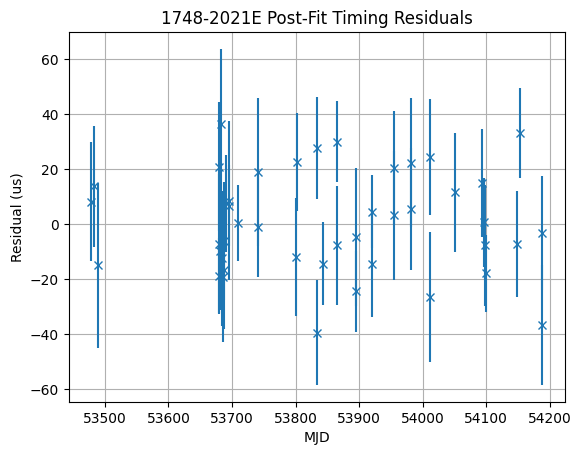

In [12]:
plt.figure()
plt.errorbar(
    xt.value,
    f.resids.time_resids.to(u.us).value,
    t.get_errors().to(u.us).value,
    fmt="x",
)
plt.title(f"{m.PSR.value} Post-Fit Timing Residuals")
plt.xlabel("MJD")
plt.ylabel("Residual (us)")
plt.grid()

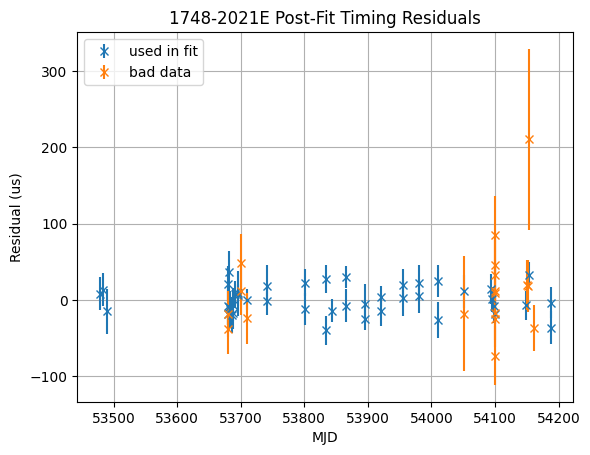

In [13]:
t_bad = t_all[~error_ok]
r_bad = Residuals(t_bad, f.model)
plt.figure()
plt.errorbar(
    xt.value,
    f.resids.time_resids.to(u.us).value,
    t.get_errors().to(u.us).value,
    fmt="x",
    label="used in fit",
)
plt.errorbar(
    t_bad.get_mjds().value,
    r_bad.time_resids.to(u.us).value,
    t_bad.get_errors().to(u.us).value,
    fmt="x",
    label="bad data",
)
plt.title(f"{m.PSR.value} Post-Fit Timing Residuals")
plt.xlabel("MJD")
plt.ylabel("Residual (us)")
plt.grid()
plt.legend(loc="upper left")

In [14]:
plt.show()

In [15]:
f.model.write_parfile("/tmp/output.par", "wt")
print(f.model.as_parfile())

# Created: 2024-04-26T18:18:44.843076
# PINT_version: 1.0
# User: docs
# Host: build-24199868-project-85767-nanograv-pint
# OS: Linux-5.19.0-1028-aws-x86_64-with-glibc2.35
# Python: 3.11.6 (main, Feb  1 2024, 16:47:41) [GCC 11.4.0]
# Format: pint
PSR                            1748-2021E
EPHEM                               DE421
CLK                          TT(BIPM2019)
UNITS                                 TDB
START              53478.2858714195382639
FINISH             54187.5873241702319097
TIMEEPH                              FB90
T2CMETHOD                        IAU2000B
DILATEFREQ                              N
DMDATA                                  N
NTOA                                   44
CHI2                    39.39611669542122
CHI2R                  1.0367399130374004
TRES                18.175665853858915125
RAJ                     17:48:52.80032123 1 0.00013868970124516312
DECJ                   -20:21:29.39582205 1 0.03403292479973538814
PMRA                           